<a href="https://colab.research.google.com/github/corvus-rex/object-detection/blob/master/ObjectDetection_POC_KopiOey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install protobuf, cython and tf-slim
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython
!pip install tf-slim

In [ ]:
# clone the master repo
!git clone https://github.com/tensorflow/models.git

In [2]:
# compile proto files
# make sure you are in BASE_DIR/research/ (see cell below)
%cd /content/drive/My Drive/Laeveteinn/KopiOey/models/research/
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

/content/drive/My Drive/Laeveteinn/KopiOey/models/research
Processing /content/drive/My Drive/Laeveteinn/KopiOey/models/research
     |████████████████████████████████| 8.3MB 10.1MB/s 
     |████████████████████████████████| 849kB 55.1MB/s 
     |████████████████████████████████| 829kB 56.7MB/s 
     |████████████████████████████████| 63.8MB 44kB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 81kB 11.3MB/s 
     |████████████████████████████████| 1.4MB 55.4MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 153kB 67.5MB/s 
     |████████████████████████████████| 174kB 60.0MB/s 
     |████████████████████████████████| 1.1MB 51.0MB/s 
     |████████████████████████████████| 102kB 14.0MB/s 
     |████████████████████████████████| 36.6MB 83kB/s 
     |████████████████████████████████| 112kB 63.1MB/s 
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=155

In [3]:
# Add path environment
PERSONAL_DIR = "/content/drive/My Drive/Laeveteinn/KopiOey/"
BASE_DIR = PERSONAL_DIR + "models/"
%set_env PYTHONPATH=/content/drive/My Drive/Laeveteinn/KopiOey/models/research:/content/drive/My Drive/Laeveteinn/KopiOey/models/research/slim
import os
os.environ['PYTHONPATH'] += ":/content/drive/My Drive/Laeveteinn/KopiOey/models"
os.environ['PYTHONPATH'] += ":/content/drive/My Drive/Laeveteinn/KopiOey/pyimagesearch"
import sys
sys.path.insert(1, os.path.join(BASE_DIR, "official"))
sys.path.insert(1, os.path.join(PERSONAL_DIR, "pyimagesearch"))
print(sys.path)

# Run build test
!python object_detection/builders/model_builder_test.py

env: PYTHONPATH=/content/drive/My Drive/Laeveteinn/KopiOey/models/research:/content/drive/My Drive/Laeveteinn/KopiOey/models/research/slim
['', '/content/drive/My Drive/Laeveteinn/KopiOey/pyimagesearch', '/content/drive/My Drive/Laeveteinn/KopiOey/models/official', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']
2020-09-04 03:57:17.867774: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [4]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import PIL

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

Num GPUs Available:  1


In [5]:
# Initialize variables
MODELS = ["centernet_resnet101_v1_fpn_512x512_coco17_tpu-8",
              "centernet_hg104_512x512_coco17_tpu-8"]
MODEL_NAME = MODELS[1]
BASE_DOWNLOAD = "http://download.tensorflow.org/models/object_detection/tf2/20200711/"
DOWNLOAD_URL = BASE_DOWNLOAD + MODEL_NAME + ".tar.gz"
MODEL_FILE = MODEL_NAME + ".tar.gz"

In [ ]:
# Download and extract tar file
import six.moves.urllib as urllib
import tarfile

opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_URL, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
tar_file.extractall(os.getcwd())

In [6]:
# Config and checkpoint dir
config_dir = BASE_DIR + "/research/object_detection/" + MODEL_NAME
pipeline_config = os.path.join(config_dir, "pipeline.config")
model_dir = BASE_DIR + "research/object_detection/" + MODEL_NAME + "/checkpoint"

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(model_dir, 'ckpt-0')).expect_partial()

print(pipeline_config)
def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

/content/drive/My Drive/Laeveteinn/KopiOey/models//research/object_detection/centernet_hg104_512x512_coco17_tpu-8/pipeline.config


In [7]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = PIL.Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [8]:
# Only detect people?
DETECT_HUMAN = True

In [9]:
# Label map
if DETECT_HUMAN:
  label_map_path = BASE_DIR + "research/object_detection/data/mscoco_peopleonly_label_map.pbtxt"
else:
  label_map_path = BASE_DIR + "research/object_detection/data/mscoco_label_map.pbtxt"
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

In [34]:
def draw_centroid(frame, centroid):
  red = (255, 0, 0)
  value = tuple(centroid)
  cv2.circle(frame, value, 1, red, 10)

def draw_text(frame, centroid, id):
  centroid = tuple(centroid)
  green = (0, 255, 0)
  font = cv2.FONT_HERSHEY_PLAIN
  cv2.putText(frame, "Person #" + str(id), centroid, font, 1, green, 1, cv2.LINE_AA)

In [ ]:
def does_intersect(centroid_new, centroid_old, roi_line):
  X1 = centroid_new[0]
  Y1 = centroid_new[1]
  X2 = centroid_old[0]
  Y2 = centroid_old[1]
  X3 = roi_line[0][0]
  Y3 = roi_line[0][1]
  X4 = roi_line[1][0]
  Y4 = roi_line[1][1]

  Segment1 = {(X1, Y1), (X2, Y2)}
  Segment2 = {(X3, Y3), (X4, Y4)}
  I1 = [min(X1,X2), max(X1,X2)]
  I2 = [min(X3,X4), max(X3,X4)]
  Ia = [max( min(X1,X2), min(X3,X4) ),
      min( max(X1,X2), max(X3,X4) )]
  if (max(X1,X2) < min(X3,X4)):
    return False  # There is no mutual abcisses
  A1 = (Y1-Y2)/(X1-X2)  #
  A2 = (Y3-Y4)/(X3-X4)  #
  b1 = Y1-A1*X1 = Y2-A1*X2
  b2 = Y3-A2*X3 = Y4-A2*X4
  if (A1 == A2):
    return False  # Parallel segments
  Ya = A1 * Xa + b1
  Ya = A2 * Xa + b2
  A1 * Xa + b1 = A2 * Xa + b2
  Xa = (b2 - b1) / (A1 - A2)   # 
  if ( (Xa < max( min(X1,X2), min(X3,X4) )) or
     (Xa > min( max(X1,X2), max(X3,X4) )) ):
    return False  # intersection is out of bound
  else:
    return True

In [18]:
# The following has been modified to fit TF2's vis util box normalized bounding box
# import the necessary packages
from scipy.spatial import distance as dist
from collections import OrderedDict
import numpy as np

class CentroidTracker():
	def __init__(self, frame_shape, maxDisappeared=50):
		# initialize the next unique object ID along with two ordered
		# dictionaries used to keep track of mapping a given object
		# ID to its centroid and number of consecutive frames it has
		# been marked as "disappeared", respectively
		self.nextObjectID = 0
		self.objects = OrderedDict()
		self.disappeared = OrderedDict()
		# Height, width and color channel of the frame
		self.height, self.width, self.channel = frame_shape

		# store the number of maximum consecutive frames a given
		# object is allowed to be marked as "disappeared" until we
		# need to deregister the object from tracking
		self.maxDisappeared = maxDisappeared

	def register(self, centroid):
		# when registering an object we use the next available object
		# ID to store the centroid
		self.objects[self.nextObjectID] = centroid
		self.disappeared[self.nextObjectID] = 0
		self.nextObjectID += 1

	def deregister(self, objectID):
		# to deregister an object ID we delete the object ID from
		# both of our respective dictionaries
		del self.objects[objectID]
		del self.disappeared[objectID]

	def update(self, frame, rects):
		# check to see if the list of input bounding box rectangles
		# is empty
		if len(rects) == 0:
			# loop over any existing tracked objects and mark them
			# as disappeared
			for objectID in list(self.disappeared.keys()):
				self.disappeared[objectID] += 1

				# if we have reached a maximum number of consecutive
				# frames where a given object has been marked as
				# missing, deregister it
				if self.disappeared[objectID] > self.maxDisappeared:
					self.deregister(objectID)

			# return early as there are no centroids or tracking info
			# to update
			return self.objects

		# initialize an array of input centroids for the current frame
		inputCentroids = np.zeros((len(rects), 2), dtype="int")

		# loop over the bounding box rectangles
		for (i, (endY, endX, startY, startX)) in enumerate(rects):
			# denormalize the bounding box coordinate
			d_minX = startX * self.height
			d_maxX = endX * self.height
			d_minY = startY * self.width
			d_maxY = endY * self.width
			# use the bounding box coordinates to derive the centroid
			cX = int((d_minX + d_maxX) / 2.0)
			cY = int((d_minY + d_maxY) / 2.0)
			inputCentroids[i] = (cX, cY)

		# if we are currently not tracking any objects take the input
		# centroids and register each of them
		if len(self.objects) == 0:
			for i in range(0, len(inputCentroids)):
				draw_centroid(frame, inputCentroids[i])
				self.register(inputCentroids[i])
				draw_text(frame, inputCentroids[i], self.nextObjectID-1)

		# otherwise, are are currently tracking objects so we need to
		# try to match the input centroids to existing object
		# centroids
		else:
			# grab the set of object IDs and corresponding centroids
			objectIDs = list(self.objects.keys())
			objectCentroids = list(self.objects.values())

			# compute the distance between each pair of object
			# centroids and input centroids, respectively -- our
			# goal will be to match an input centroid to an existing
			# object centroid
			D = dist.cdist(np.array(objectCentroids), inputCentroids)

			# in order to perform this matching we must (1) find the
			# smallest value in each row and then (2) sort the row
			# indexes based on their minimum values so that the row
			# with the smallest value as at the *front* of the index
			# list
			rows = D.min(axis=1).argsort()

			# next, we perform a similar process on the columns by
			# finding the smallest value in each column and then
			# sorting using the previously computed row index list
			cols = D.argmin(axis=1)[rows]

			# in order to determine if we need to update, register,
			# or deregister an object we need to keep track of which
			# of the rows and column indexes we have already examined
			usedRows = set()
			usedCols = set()

			# loop over the combination of the (row, column) index
			# tuples
			for (row, col) in zip(rows, cols):
				# if we have already examined either the row or
				# column value before, ignore it
				# val
				if row in usedRows or col in usedCols:
					continue

				# otherwise, grab the object ID for the current row,
				# set its new centroid, and reset the disappeared
				# counter
				objectID = objectIDs[row]
				self.objects[objectID] = inputCentroids[col]
				self.disappeared[objectID] = 0
				draw_centroid(frame, inputCentroids[col])
				draw_text(frame, inputCentroids[col], objectID)

				# indicate that we have examined each of the row and
				# column indexes, respectively
				usedRows.add(row)
				usedCols.add(col)

			# compute both the row and column index we have NOT yet
			# examined
			unusedRows = set(range(0, D.shape[0])).difference(usedRows)
			unusedCols = set(range(0, D.shape[1])).difference(usedCols)

			# in the event that the number of object centroids is
			# equal or greater than the number of input centroids
			# we need to check and see if some of these objects have
			# potentially disappeared
			if D.shape[0] >= D.shape[1]:
				# loop over the unused row indexes
				for row in unusedRows:
					# grab the object ID for the corresponding row
					# index and increment the disappeared counter
					objectID = objectIDs[row]
					self.disappeared[objectID] += 1

					# check to see if the number of consecutive
					# frames the object has been marked "disappeared"
					# for warrants deregistering the object
					if self.disappeared[objectID] > self.maxDisappeared:
						self.deregister(objectID)

			# otherwise, if the number of input centroids is greater
			# than the number of existing object centroids we need to
			# register each new input centroid as a trackable object
			else:
				for col in unusedCols:
					self.register(inputCentroids[col])
					draw_centroid(frame, inputCentroids[col])
					draw_text(frame, inputCentroids[col], self.nextObjectID-1)

		# return the set of trackable objects
		return self.objects

In [12]:
def confidence_pruning(boxes, scores, min_threshold=0.3):
  indices = np.squeeze(np.argwhere(scores >= min_threshold))
  boxes_pruned = boxes[[indices]]
  if boxes_pruned.ndim < 2:
    boxes_pruned = np.expand_dims(boxes_pruned, axis=0)
  return boxes_pruned

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a differe

[0.29308704 0.2560783  0.7109784  0.35772008]


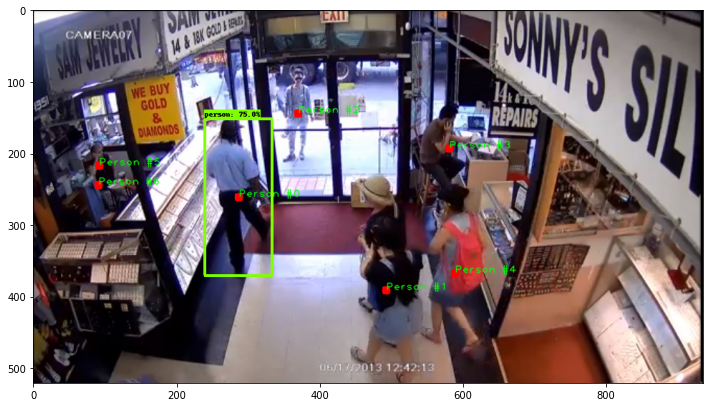

In [40]:
# Testing model with still frame image

from IPython.display import clear_output, Image
import base64
import cv2

# Image Preparation
image_dir = PERSONAL_DIR + "evaluation_data/"
image_path = os.path.join(image_dir, 'stillframe0.jpg')
image_np = load_image_into_numpy_array(image_path)  # load image as np array
Tracker = CentroidTracker([936,521,3], maxDisappeared=50)

# Detection
input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1  # COCO dataset Class starts at index 1
image_np_with_detections = image_np.copy()  # for matplotlib display

if DETECT_HUMAN:
  selected_class = 1  # only selects one class from COCO dataset, 'Person'

# If Detect Human only is turned on, only display boxes, classes and scores
# that detects human in the image
if DETECT_HUMAN:
  # Indices where class == human
  indices = np.squeeze(np.argwhere((detections['detection_classes'][0] + label_id_offset) == selected_class))
  boxes = detections['detection_boxes'][0].numpy()
  boxes = boxes[[indices]]  # select corresponding array indices of the 4-point box
  classes = (detections['detection_classes'][0] + label_id_offset).numpy()
  classes = classes[[indices]]  # select corresponding array of the detected class
  scores = detections['detection_scores'][0].numpy()
  scores = scores[[indices]]  # select corresponding scores of the detected class
  boxes = confidence_pruning(boxes, scores, 0.3)
  print(boxes[0])
else:
  boxes = detections['detection_boxes'][0].numpy()
  classes = (detections['detection_classes'][0].numpy() + label_id_offset).astype(int)
  scores = detections['detection_scores'][0].numpy()

People = Tracker.update(image_np_with_detections, boxes)

# Draw boxes and labels on the frame
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=1,
      min_score_thresh=.25,  # minimum score for object to be considered as detected
      agnostic_mode=False)

# Matplotlib
plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

In [36]:
import cv2
import time

eval_dir = PERSONAL_DIR + "evaluation_data/"
video_path = eval_dir + "sample1.mp4"
out_dir = eval_dir + "out_hourglass3.mp4"

cap = cv2.VideoCapture(video_path)
res=(928,576)  #resolution
fourcc = cv2.VideoWriter_fourcc('M','J','P','G') #codec
out = cv2.VideoWriter(out_dir, fourcc, 20.0, res)
label_id_offset = 1  # COCO dataset Class starts at index 1
frame_shape = list(res)
frame_shape.append(3)
Tracker = CentroidTracker(frame_shape, maxDisappeared=50)
min_threshold = 0.3  # minimum score for detection before they are displayed

if DETECT_HUMAN:
  selected_class = 1  # only selects one class from COCO dataset, 'Person'

duration = 500
start_time = time.time()
while (int(time.time() - start_time) <= duration):
  ret, frame_np = cap.read()

  if not ret:
    break

  # Detection
  input_tensor = tf.convert_to_tensor(np.expand_dims(frame_np, 0), dtype=tf.float32)
  detections, predictions_dict, shapes = detect_fn(input_tensor)

  frame_np_with_detections = frame_np.copy()  # for matplotlib display

  # If Detect Human only is turned on, only display boxes, classes and scores
  # that detects human in the image
  if DETECT_HUMAN:
    # Indices where class == human
    indices = np.squeeze(np.argwhere((detections['detection_classes'][0] + label_id_offset) == selected_class))
    boxes = detections['detection_boxes'][0].numpy()
    boxes = boxes[[indices]]  # select corresponding array indices of the 4-point box
    classes = (detections['detection_classes'][0] + label_id_offset).numpy()
    classes = classes[[indices]]  # select corresponding array of the detected class
    scores = detections['detection_scores'][0].numpy()
    scores = scores[[indices]]  # select corresponding array of scores of detected class
    boxes = confidence_pruning(boxes, scores, min_threshold) # prune boxes lower than min threshold score
  else:
    boxes = detections['detection_boxes'][0].numpy()
    classes = (detections['detection_classes'][0].numpy() + label_id_offset).astype(int)
    scores = detections['detection_scores'][0].numpy()

  People = Tracker.update(frame_np_with_detections, boxes)

  # Draw boxes and labels on the frame
  viz_utils.visualize_boxes_and_labels_on_image_array(
        frame_np_with_detections,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=min_threshold,
        agnostic_mode=False)
  
  out.write(frame_np_with_detections)

cap.release()
out.release()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a differe

In [ ]:
from scipy.spatial import distance
coords0 = [(35.0456, -85.2672),
          (35.1174, -89.9711),
          (35.9728, -83.9422),
          (36.1667, -86.7833)]
coords1 = [(35.2346, -82.0923),
          (31.3567, -81.3591),
          (33.6858, -86.1278)]
D = distance.cdist(coords0, coords1, 'euclidean')
print(D)
rows = D.min(axis=1).argsort()
print(rows)
cols = D.argmin(axis=1)[rows]
print(cols)

[[3.18052056 5.37412587 1.60925088]
 [7.87967165 9.39730858 4.10127217]
 [1.9917503  5.28968665 3.16341846]
 [4.78270754 7.2496928  2.56603684]]
[0 2 3 1]
[2 0 2 2]
